# Signal Approximation by neural network

We will reproduce some experiment of the paper "Implicit Neural Representations with Periodic Activation Functions" (Sitzmann, Martel et al.)
https://www.vincentsitzmann.com/siren/



In [32]:
#import packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import random
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from itertools import product

#define device to speed up on gpu, if you can
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
#dev = "cpu"

device = torch.device(dev)  
global device
print("Device :",device)

#Utils function :
#based on a model, reconstruct the image
#create the dataset based on a image file
#warning : the loss of the image is not based on the image reconstruction but based on pixel prediction

def show_image(image,index,title="Ground truth"):
    image =(image*255.0).astype(np.uint8)
    plt.figure(index)
    plt.title(title)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
def reconstruct_image(model,index=0,title="Reconstruct image"):
    size_x = 256
    size_y = 256
    channels = 3
    image = np.zeros((size_x,size_y,channels))
    
    x_channel = torch.arange(0,256)/256
    y_channel = torch.arange(0,256)/256

    x_channel = x_channel.view(-1,1)
    y_channel = y_channel.view(1,-1)

    x_channel = x_channel.repeat(1, 256)
    y_channel = y_channel.repeat(256, 1)

    x_channel = x_channel.view(-1)
    y_channel = y_channel.view(-1)


    xy_channel = torch.stack([x_channel,y_channel],dim=-1)
    raw_image = model(xy_channel).cpu()
    image = torch.reshape(raw_image, (size_x,size_y,3)).detach().numpy()


    show_image(image,index,title)
    
def create_dataset(image):#dataset with r,g,b in [0,1]
    size_x = image.shape[0]
    size_y = image.shape[1]
    channels = image.shape[2]
    
    x_data = np.zeros((size_x*size_y,2))
    y_labels = np.zeros((size_x*size_y,channels))
    for i in range(size_x):
        for j in range(size_y):
            x_ = i/size_x
            y_ = j/size_y
            #print([x_,y_])
            #print(y_labels.shape)
            x_data[i*size_y+j] = [x_,y_]
            y_labels[i*size_y+j] = image[i][j]/255.0
    return x_data,y_labels




#The models to predict, based on the data (coordinate (x,y)), the label (pixel (r,g,b))

#by Vincent Sitzmann, Implicit Neural Representations with Periodic Activation Functions
#https://www.vincentsitzmann.com/siren/
class SineLayer(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias).to(device)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.to(device)
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output#, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations
    
    
#based on David Brellmann, "Fourier Features in Reinforcement Learning with Neural Networks"
#https://openreview.net/forum?id=VO7bAwdWRjg
class fourier_extract_full(nn.Linear):
    def __init__(self, in_features:int, order:int):
        self.order = order
        self.in_features = in_features
        super().__init__(in_features, (order+1)**in_features, bias=True)
        c=np.array(list(product(range(order + 1), repeat=in_features)))
        with torch.no_grad():
            self.weight.copy_(torch.tensor(c, dtype=torch.float32))
        self.weight.requires_grad = False

    def get_output_size(self,):
        return (self.order+1)**self.in_features

    def forward(self, x:torch.Tensor)->torch.Tensor:
        ##print(x.size())
        x = x.to(device)
        x = np.pi*super().forward(x)
        return torch.cos(x)
    
    
#code by me
class simple_mlp(nn.Module):
    def __init__(self,):
        super(simple_mlp, self).__init__()
        self.fc_1 = nn.Linear(2,64).to(device)
        self.fc_2 = nn.Linear(64,64).to(device)
        self.fc_3 = nn.Linear(64,3).to(device)

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x
    
#code by me, based on fourier_extract_full
class fourier_mlp(nn.Module):
    def __init__(self,):
        super(fourier_mlp, self).__init__()
        self.fourier_1 = fourier_extract_full(2,8).to(device)
        self.fc_2 = nn.Linear(self.fourier_1.get_output_size(),64).to(device)
        self.fc_3 = nn.Linear(64,64).to(device)
        self.fc_4 = nn.Linear(64,3).to(device)

    def forward(self, x):
        x = x.to(device)
        x = self.fourier_1(x)
        x = F.relu(self.fc_2(x))
        x = F.relu(self.fc_3(x))
        x = self.fc_4(x)
        return x
    
#code by me, based on Siren
class siren_mlp(nn.Module):
    def __init__(self,):
        super(siren_mlp, self).__init__()
        #sorry for this litle trick, the original paper predict only one value
        self.siren_r = Siren(in_features=2, out_features=1, hidden_features=64, hidden_layers=1, outermost_linear=True).to(device)
        self.siren_g = Siren(in_features=2, out_features=1, hidden_features=64, hidden_layers=1, outermost_linear=True).to(device)
        self.siren_b = Siren(in_features=2, out_features=1, hidden_features=64, hidden_layers=1, outermost_linear=True).to(device)

    def forward(self,x):
        x = x.to(device)
        return torch.cat([self.siren_r(x),self.siren_g(x),self.siren_b(x),],dim=-1)
    
    
#code by me
class triangular_features_extraction(nn.Linear):
    def __init__(self, in_features:int, order:int,flatten=True):
        self.flatten = flatten
        self.order = order
        self.in_features = in_features
        self.size_ecart = 1/(self.order-1)
        self.var_power = 2.0
        
        self.size_pic = self.var_power*self.size_ecart

        super().__init__(in_features, (order)*in_features, bias=True)


    def forward(self, x:torch.Tensor)->torch.Tensor:
        x = x.type(torch.float64).to(device)
        out= torch.zeros(x.shape[0],x.shape[1],self.order).to(device)

        
        for i in range(self.order):
            out[:,:,i] = x-i*self.size_ecart
        mean = self.size_pic
        out = torch.min(torch.relu(out+self.size_pic),torch.relu(self.size_pic-out)).to(device)/(self.size_pic)
        
        
        if self.flatten:
            return torch.flatten(out, start_dim=1)
        else:
            return out#torch.flatten(out, start_dim=1)

#code by me
class triangular_mlp(nn.Module):
    def __init__(self,):
        super(triangular_mlp, self).__init__()
        self.triangular_extraction = triangular_features_extraction(2,8).to(device)
        self.fc_1 = nn.Linear(16,64).to(device)
        self.fc_2 = nn.Linear(64,3).to(device)
        #self.fc_3 = nn.Linear(64,3).to(device)

    def forward(self, x):
        x = x.to(device)
        x = self.triangular_extraction(x)
        x = F.relu(self.fc_1(x))
        #x = F.relu(self.fc_2(x))
        x = self.fc_2(x)
        return x
        
#we define the trainning loop
def train_model(
    model=simple_mlp(),
    dataset=create_dataset(cv2.imread("lena.png")),
    epochs=10,
    plot_step=1,
    ):
    loss_func = torch.nn.MSELoss()
    dataset = TensorDataset( torch.Tensor(dataset[0]), torch.Tensor(dataset[1]) )
    dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_array = []


    for epoch in range(epochs):

        for id_batch, (inputs, labels) in enumerate(dataloader):
                optimizer.zero_grad()
                labels_predict = model(inputs).cpu()
                loss_train = loss_func(labels_predict, labels)
                loss_train.backward()
                optimizer.step()
                loss_array.append(loss_train.detach().numpy())
                #print(id_batch)
                if id_batch==0:
                    if epoch%plot_step==0:
                        print('Epoch: %d, Loss_train: %.3f ' % (epoch+1, loss_train))
    plt.figure(42)
    plt.title("Loss curve")
    plt.xlabel("Trainning")
    plt.ylabel("Loss")
    plt.plot(loss_array)
    print("Finished with a loss for 100 last loss : ",np.mean(loss_array[-100:]))
    print("Finished with a loss for 50 last loss : ",np.mean(loss_array[-50:]))
    




Device : cuda:0


# We will benchmark different way to extract the data to obtain the pixel prediction

The extraction :

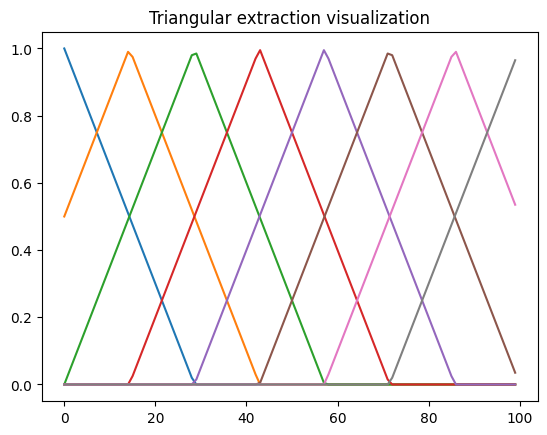

In [33]:
layer = triangular_features_extraction(100,8,flatten=False)
input_x = torch.arange(0,100)/100
input_x = input_x.view(1,-1)
output_y = layer(input_x).cpu()
plt.title("Triangular extraction visualization")
plt.plot(output_y[0])


torch.Size([1, 100, 1])


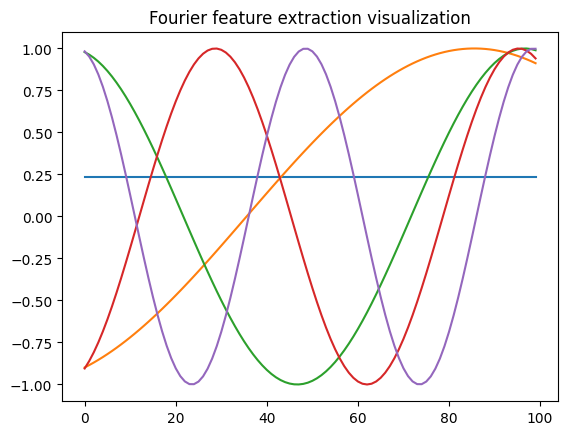

In [34]:
layer = fourier_extract_full(1,4).to(device)

input_x = torch.arange(0,100)/100
input_x = input_x.view(1,-1,1).to(device)
print(input_x.shape)
output_y = layer(input_x).cpu()
plt.title("Fourier feature extraction visualization")
plt.plot(output_y[0].detach().numpy())

torch.Size([1, 100, 1])


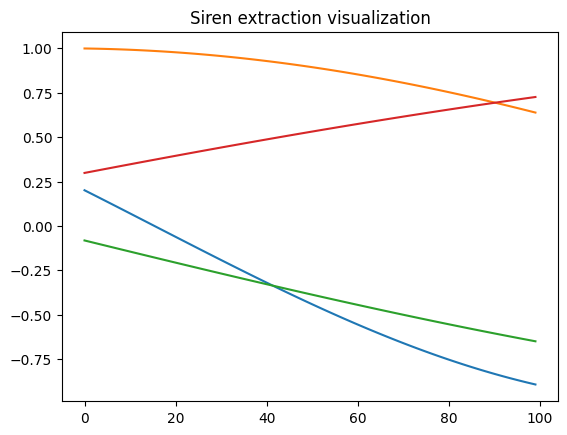

In [35]:
layer = SineLayer(1,4).to(device)

input_x = torch.arange(0,100)/100
input_x = input_x.view(1,-1,1).to(device)
print(input_x.shape)
output_y = layer(input_x).cpu()
plt.title("Siren extraction visualization")
plt.plot(output_y[0].detach().numpy())

The test of the model :

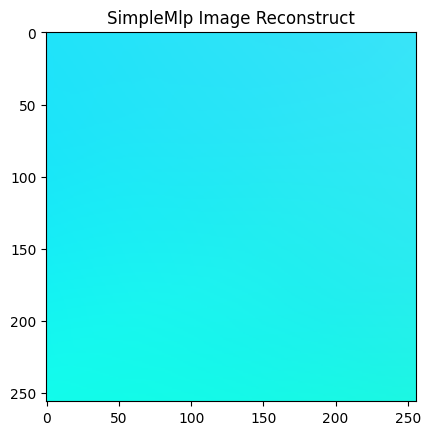

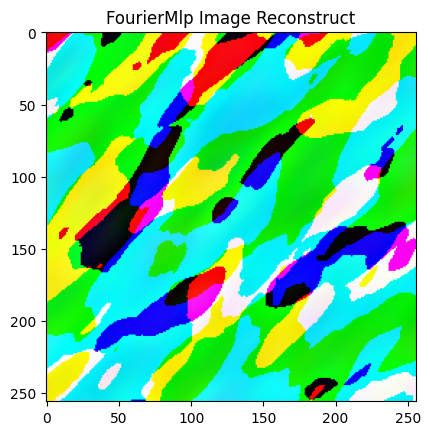

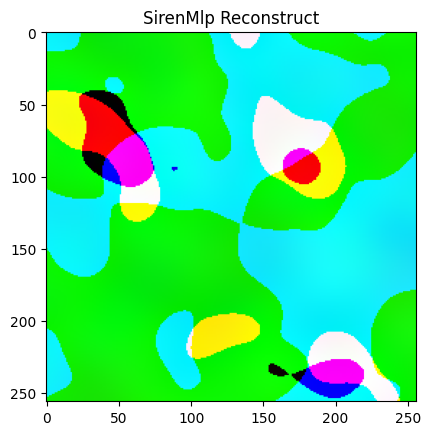

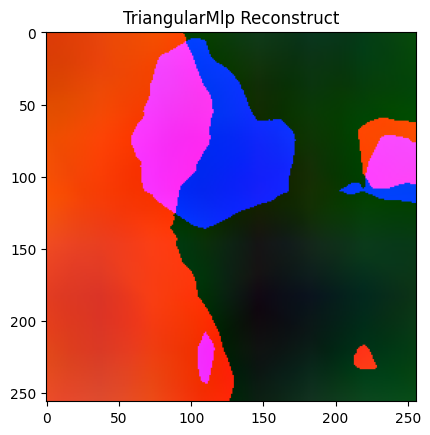

In [36]:
#Verify all model and show data
model = simple_mlp()
reconstruct_image(model,1,"SimpleMlp Image Reconstruct")

model = fourier_mlp()
reconstruct_image(model,2,"FourierMlp Image Reconstruct")

model = siren_mlp()
reconstruct_image(model,3,"SirenMlp Reconstruct")

model = triangular_mlp()
reconstruct_image(model,4,"TriangularMlp Reconstruct")



The data :

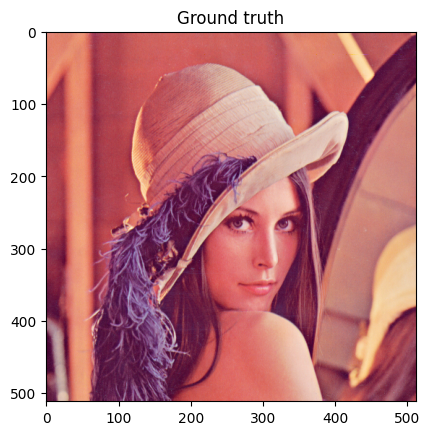

In [37]:
show_image(cv2.imread("lena.png")/255.0,5)

# Result of the image prediction

Epoch: 1, Loss_train: 0.275 
Epoch: 2, Loss_train: 0.029 
Epoch: 3, Loss_train: 0.026 
Epoch: 4, Loss_train: 0.025 
Epoch: 5, Loss_train: 0.024 
Epoch: 6, Loss_train: 0.022 
Epoch: 7, Loss_train: 0.021 
Epoch: 8, Loss_train: 0.020 
Epoch: 9, Loss_train: 0.019 
Epoch: 10, Loss_train: 0.019 
Finished with a loss for 100 last loss :  0.018880373
Finished with a loss for 50 last loss :  0.018980939
simple_mlp(
  (fc_1): Linear(in_features=2, out_features=64, bias=True)
  (fc_2): Linear(in_features=64, out_features=64, bias=True)
  (fc_3): Linear(in_features=64, out_features=3, bias=True)
)


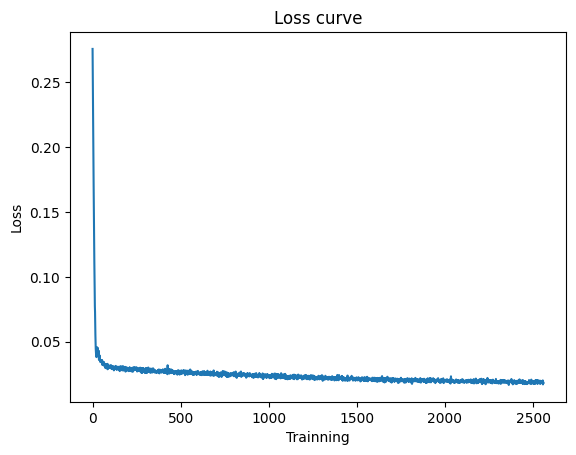

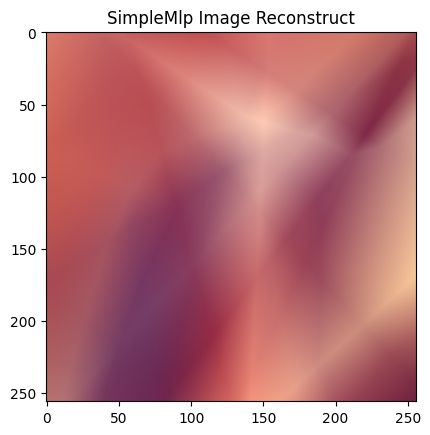

In [38]:
model = simple_mlp()
train_model(model)
reconstruct_image(model,1,"SimpleMlp Image Reconstruct")
print(model)

Epoch: 1, Loss_train: 0.359 
Epoch: 2, Loss_train: 0.011 
Epoch: 3, Loss_train: 0.008 
Epoch: 4, Loss_train: 0.007 
Epoch: 5, Loss_train: 0.005 
Epoch: 6, Loss_train: 0.005 
Epoch: 7, Loss_train: 0.004 
Epoch: 8, Loss_train: 0.004 
Epoch: 9, Loss_train: 0.004 
Epoch: 10, Loss_train: 0.004 
Finished with a loss for 100 last loss :  0.0038447285
Finished with a loss for 50 last loss :  0.0038319174
fourier_mlp(
  (fourier_1): fourier_extract_full(in_features=2, out_features=81, bias=True)
  (fc_2): Linear(in_features=81, out_features=64, bias=True)
  (fc_3): Linear(in_features=64, out_features=64, bias=True)
  (fc_4): Linear(in_features=64, out_features=3, bias=True)
)


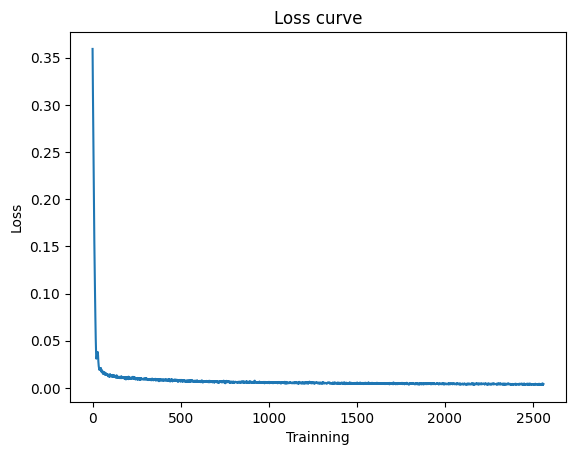

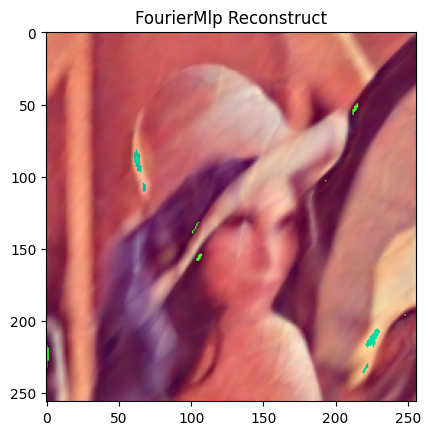

In [39]:
model = fourier_mlp()
train_model(model)
reconstruct_image(model,2,"FourierMlp Reconstruct")
print(model)

Epoch: 1, Loss_train: 0.333 
Epoch: 2, Loss_train: 0.006 
Epoch: 3, Loss_train: 0.005 
Epoch: 4, Loss_train: 0.005 
Epoch: 5, Loss_train: 0.005 
Epoch: 6, Loss_train: 0.006 
Epoch: 7, Loss_train: 0.006 
Epoch: 8, Loss_train: 0.005 
Epoch: 9, Loss_train: 0.005 
Epoch: 10, Loss_train: 0.005 
Finished with a loss for 100 last loss :  0.004813349
Finished with a loss for 50 last loss :  0.00483446
siren_mlp(
  (siren_r): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=2, out_features=64, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=64, out_features=64, bias=True)
      )
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (siren_g): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=2, out_features=64, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=64, out_features=64, bias=True)
      )
      (2): Linear(in_features=64, out_fea

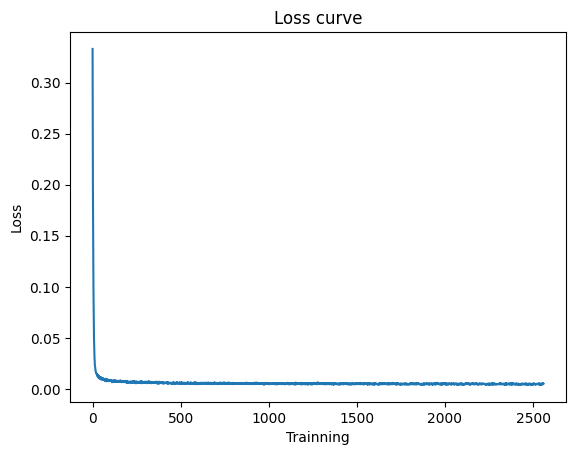

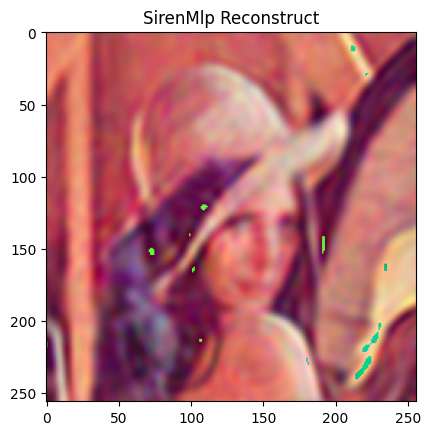

In [40]:
model = siren_mlp()
train_model(model)
reconstruct_image(model,4,"SirenMlp Reconstruct")
print(model)

Epoch: 1, Loss_train: 0.292 
Epoch: 2, Loss_train: 0.023 
Epoch: 3, Loss_train: 0.020 
Epoch: 4, Loss_train: 0.016 
Epoch: 5, Loss_train: 0.014 
Epoch: 6, Loss_train: 0.013 
Epoch: 7, Loss_train: 0.013 
Epoch: 8, Loss_train: 0.012 
Epoch: 9, Loss_train: 0.012 
Epoch: 10, Loss_train: 0.012 
Finished with a loss for 100 last loss :  0.011075617
Finished with a loss for 50 last loss :  0.0110472385
triangular_mlp(
  (triangular_extraction): triangular_features_extraction(in_features=2, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=64, bias=True)
  (fc_2): Linear(in_features=64, out_features=3, bias=True)
)


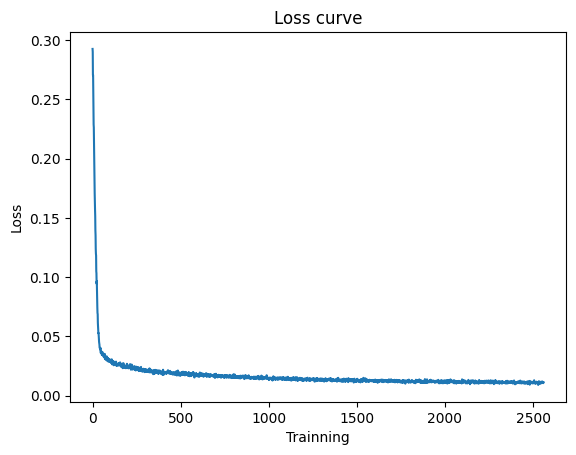

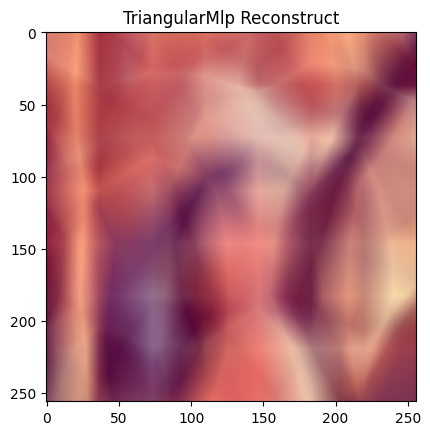

In [41]:
model = triangular_mlp()
train_model(model)
reconstruct_image(model,4,"TriangularMlp Reconstruct")
print(model)


# After the image reconstruction, the 2D signal reconstruction :

### 

In [42]:

def show_data(data,labels,index,title="Ground truth",size=128):
    X,Y,Z = data[:,0],data[:,1],labels

    X = np.reshape(X,(size,size))
    Y = np.reshape(Y,(size,size))
    Z = np.reshape(Z,(size,size))
    
    fig = plt.figure(index,figsize=(4, 4))
    #plt.title(title)
    fig.suptitle(title)
    ax = fig.add_subplot()
    scats = ax.scatter(X,Y,c=Z, cmap = "RdBu")#RdBu
    #fig.colorbar(scats)
    
def reconstruct_Helmholtz(model,index=1,title="Reconstruct image",size=128):
    size_x = size
    size_y = size
    channels = 1
    
    
    image = np.zeros((size_x,size_y,channels))
    x_channel = (torch.arange(0,size_x)/size_x)*2 -1
    y_channel = (torch.arange(0,size_y)/size_y)*2 -1
    x_channel = x_channel.view(-1,1)
    y_channel = y_channel.view(1,-1)
    x_channel = x_channel.repeat(1, size_x)
    y_channel = y_channel.repeat(size_y, 1)

    x_channel = x_channel.view(-1)
    y_channel = y_channel.view(-1)


    xy_channel = torch.stack([x_channel,y_channel],dim=-1)
    raw_image = model(xy_channel).cpu()

    show_data(xy_channel.detach(),raw_image.detach(),index,title,size)
    
    

def create_dataset_Helmholtz(size=128,size_sin=4):
    size_x=size
    size_y=size
    x_data = np.zeros((size_x*size_y,2))
    y_labels = np.zeros((size_x*size_y,1))
    for i in range(size_x):
        for j in range(size_y):
            x_ = (i/size_x)*2-1
            y_ = (j/size_y)*2-1

            x_data[i*size_y+j] = [x_,y_]
            R = np.sqrt((x_)**2 + y_**2)
            y_labels[i*size_y+j] = np.sin(R*3.1415*size_sin) 
    return x_data,y_labels
def create_dataset_Helmholtz_max(size=128):
    return create_dataset_Helmholtz(size=128,size_sin=10)


def create_dataset_hard(size=128):
    size_x=size
    size_y=size
    x_data = np.zeros((size_x*size_y,2))
    y_labels = np.zeros((size_x*size_y,1))
    for i in range(size_x):
        for j in range(size_y):
            x_ = (i/size_x)*2-1
            y_ = (j/size_y)*2-1

            x_data[i*size_y+j] = [x_,y_]
            y_labels[i*size_y+j] = np.sin(3.1415*(2*x_+3*y_)*2*x_+random.random())
            
            
    return x_data,y_labels



The 2D signal to Reconstruct :

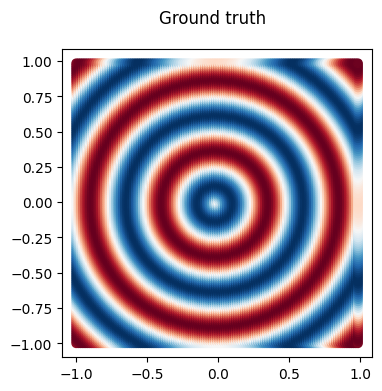

In [43]:
(data,label) = create_dataset_Helmholtz(size=128)
show_data(data,label,1,size=128)

To solve this task, we can choose between 2 types of neural network :

    minimal : Obtain reconstruction with the smaller model to see the benefits and limits of each way to extract the data
    maximal : Obtain a reconstruction with the higher accuracy (with bigger model), to test the model on harder task after that

In [44]:
#Minimal neural network
class simple_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(simple_mlp_Helmholtz, self).__init__()
        self.fc_1 = nn.Linear(2,32).to(device)
        self.fc_2 = nn.Linear(32,1).to(device)
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x
    
class triangular_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(triangular_mlp_Helmholtz, self).__init__()
        self.input_decompo = triangular_features_extraction(2,8).to(device)
        self.fc_1 = nn.Linear(16,1).to(device)
        #self.fc_2 = nn.Linear(32,1).to(device)


    def forward(self, x):
        x = x.to(device)
        x = self.input_decompo((x+1)/2)
        #x = F.relu(self.fc_1(x))
        x = self.fc_1(x)
        return x
#code by me
class fourier_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(fourier_mlp_Helmholtz, self).__init__()
        self.fourier_1 = fourier_extract_full(2,4).to(device)
        self.fc_2 = nn.Linear(self.fourier_1.get_output_size(),1).to(device)
        #self.fc_3 = nn.Linear(64,1).to(device)


    def forward(self, x):
        x = x.to(device)
        x = self.fourier_1(x)
        #x = F.relu(self.fc_2(x))
        x = self.fc_2(x)
        return x
    
#code by me
class siren_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(siren_mlp_Helmholtz, self).__init__()
        self.siren = Siren(in_features=2, out_features=1, hidden_features=16, hidden_layers=0, outermost_linear=False).to(device)

    def forward(self,x):
        x = x.to(device)
        return self.siren(x)
    


In [45]:
#Normal model
class simple_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(simple_mlp_Helmholtz, self).__init__()
        self.fc_1 = nn.Linear(2,32).to(device)
        self.fc_2 = nn.Linear(32,32).to(device)
        self.fc_3 = nn.Linear(32,1).to(device)
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x
    
class siren_fake_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(siren_fake_mlp_Helmholtz, self).__init__()
        self.fc_1 = nn.Linear(2,32).to(device)
        self.fc_2 = nn.Linear(32,32).to(device)
        self.fc_3 = nn.Linear(32,1).to(device)
    def forward(self, x):
        x = x.to(device)
        x = torch.sin(self.fc_1(x))
        x = torch.sin(self.fc_2(x))
        x = self.fc_3(x)
        return x
    
class triangular_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(triangular_mlp_Helmholtz, self).__init__()
        self.input_decompo = triangular_features_extraction(2,8).to(device)
        self.fc_1 = nn.Linear(16,32).to(device)
        self.fc_2 = nn.Linear(32,1).to(device)


    def forward(self, x):
        x = x.to(device)
        x = self.input_decompo((x+1)/2)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x
    
    
#code by me
class fourier_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(fourier_mlp_Helmholtz, self).__init__()
        self.fourier_1 = fourier_extract_full(2,8).to(device)
        self.fc_2 = nn.Linear(self.fourier_1.get_output_size(),32).to(device)
        self.fc_3 = nn.Linear(32,1).to(device)


    def forward(self, x):
        x = x.to(device)
        x = self.fourier_1(x)
        x = F.relu(self.fc_2(x))
        x = self.fc_3(x)
        return x
    
#code by me
class siren_mlp_Helmholtz(nn.Module):
    def __init__(self,):
        super(siren_mlp_Helmholtz, self).__init__()
        self.siren = Siren(in_features=2, out_features=1, hidden_features=32, hidden_layers=1, outermost_linear=False).to(device)

    def forward(self,x):
        x = x.to(device)
        return self.siren(x)
    

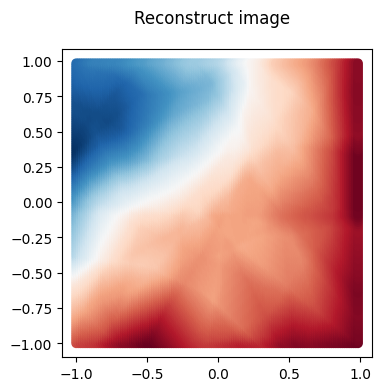

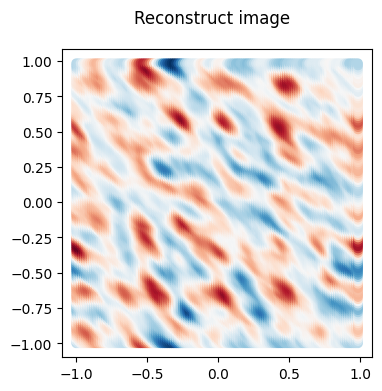

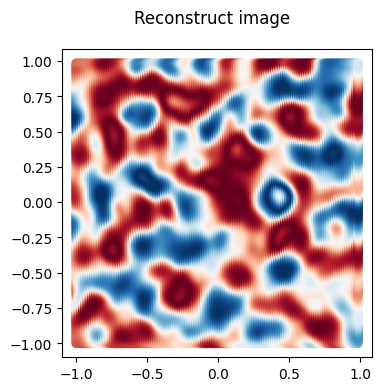

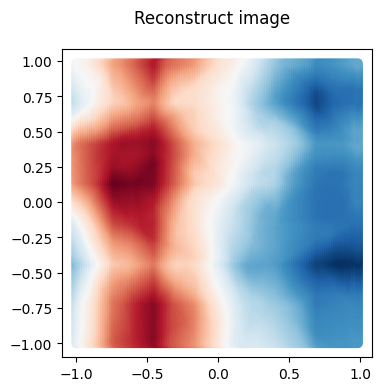

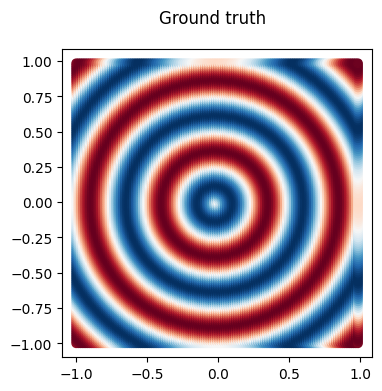

In [46]:
#Verify models and data 
model = simple_mlp_Helmholtz()
reconstruct_Helmholtz(model,index=1)

model = fourier_mlp_Helmholtz()
reconstruct_Helmholtz(model,index=2)

model = siren_mlp_Helmholtz()
reconstruct_Helmholtz(model,index=3)

model = triangular_mlp_Helmholtz()
reconstruct_Helmholtz(model,index=4)


(data,label) = create_dataset_Helmholtz(size=128)
show_data(data,label,5,size=128)


# Result of the 2D signal approximation, easy version

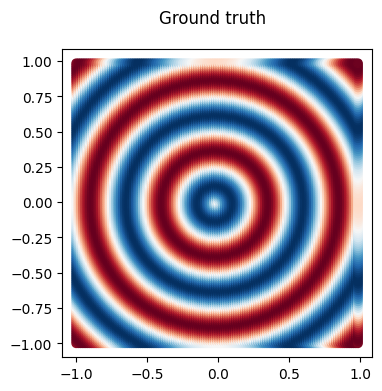

In [47]:
#Simple data
(data,label) = create_dataset_Helmholtz(size=128)
show_data(data,label,5,size=128)

Epoch: 1, Loss_train: 0.551 
Epoch: 51, Loss_train: 0.294 
Epoch: 101, Loss_train: 0.137 
Epoch: 151, Loss_train: 0.079 
Epoch: 201, Loss_train: 0.052 
Epoch: 251, Loss_train: 0.037 
Epoch: 301, Loss_train: 0.037 
Epoch: 351, Loss_train: 0.025 
Epoch: 401, Loss_train: 0.022 
Epoch: 451, Loss_train: 0.017 
Finished with a loss for 100 last loss :  0.0162762
Finished with a loss for 50 last loss :  0.016251259
simple_mlp_Helmholtz(
  (fc_1): Linear(in_features=2, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


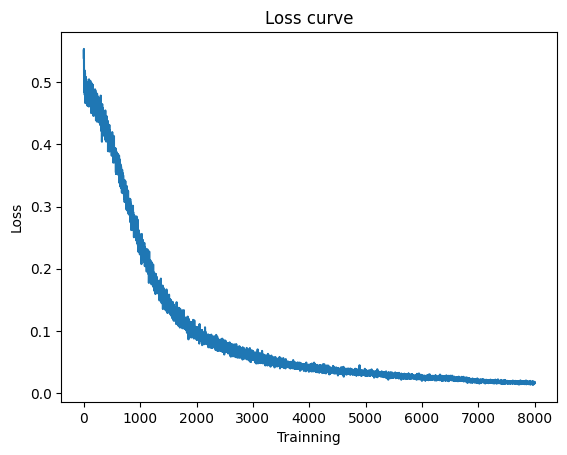

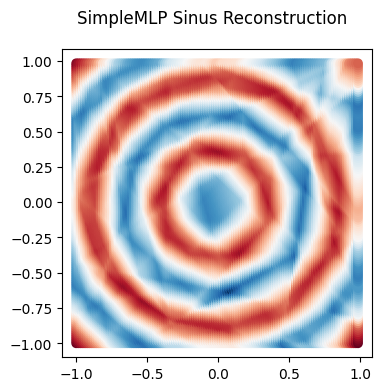

In [48]:
model = simple_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=1,title="SimpleMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.505 
Epoch: 51, Loss_train: 0.499 
Epoch: 101, Loss_train: 0.486 
Epoch: 151, Loss_train: 0.470 
Epoch: 201, Loss_train: 0.451 
Epoch: 251, Loss_train: 0.467 
Epoch: 301, Loss_train: 0.447 
Epoch: 351, Loss_train: 0.441 
Epoch: 401, Loss_train: 0.373 
Epoch: 451, Loss_train: 0.315 
Finished with a loss for 100 last loss :  0.26363218
Finished with a loss for 50 last loss :  0.25946572
siren_fake_mlp_Helmholtz(
  (fc_1): Linear(in_features=2, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


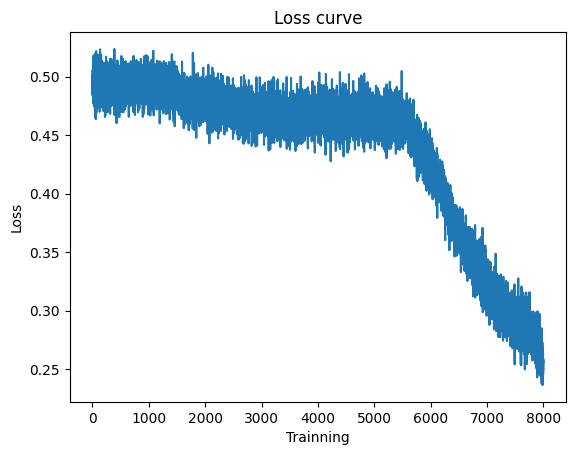

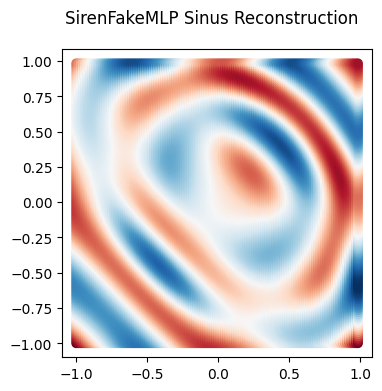

In [49]:
model = siren_fake_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=1,title="SirenFakeMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.532 
Epoch: 51, Loss_train: 0.001 
Epoch: 101, Loss_train: 0.001 
Epoch: 151, Loss_train: 0.000 
Epoch: 201, Loss_train: 0.000 
Epoch: 251, Loss_train: 0.000 
Epoch: 301, Loss_train: 0.000 
Epoch: 351, Loss_train: 0.000 
Epoch: 401, Loss_train: 0.000 
Epoch: 451, Loss_train: 0.000 
Finished with a loss for 100 last loss :  0.00027345942
Finished with a loss for 50 last loss :  0.00027292175
fourier_mlp_Helmholtz(
  (fourier_1): fourier_extract_full(in_features=2, out_features=81, bias=True)
  (fc_2): Linear(in_features=81, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


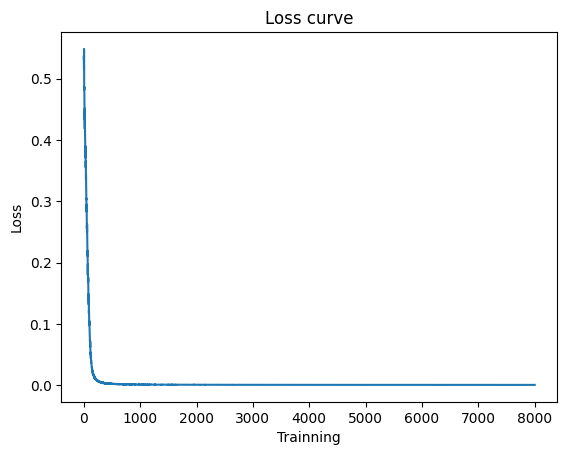

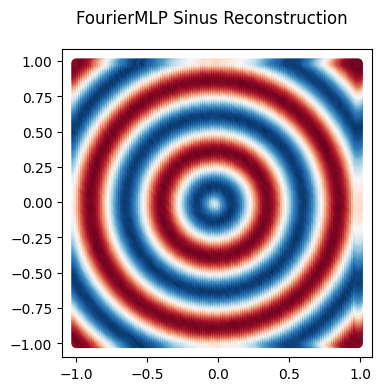

In [50]:

model = fourier_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=2,title="FourierMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 1.098 
Epoch: 51, Loss_train: 0.045 
Epoch: 101, Loss_train: 0.034 
Epoch: 151, Loss_train: 0.031 
Epoch: 201, Loss_train: 0.026 
Epoch: 251, Loss_train: 0.023 
Epoch: 301, Loss_train: 0.023 
Epoch: 351, Loss_train: 0.021 
Epoch: 401, Loss_train: 0.027 
Epoch: 451, Loss_train: 0.021 
Finished with a loss for 100 last loss :  0.024725337
Finished with a loss for 50 last loss :  0.024894219
siren_mlp_Helmholtz(
  (siren): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=2, out_features=32, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=32, out_features=32, bias=True)
      )
      (2): SineLayer(
        (linear): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
)


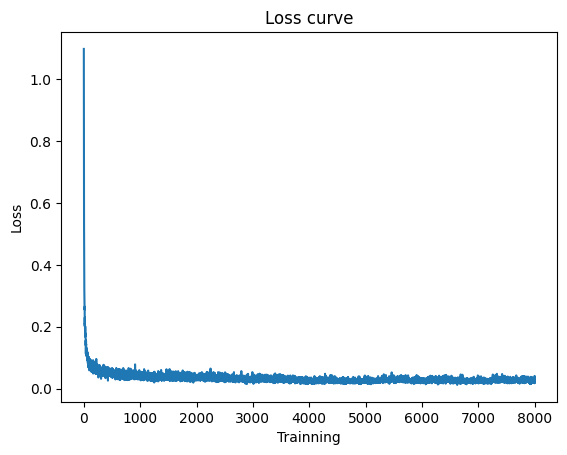

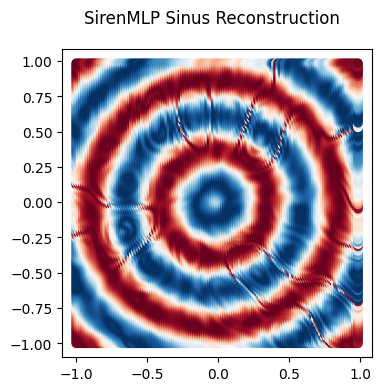

In [51]:
model = siren_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=4,title="SirenMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.560 
Epoch: 51, Loss_train: 0.181 
Epoch: 101, Loss_train: 0.041 
Epoch: 151, Loss_train: 0.019 
Epoch: 201, Loss_train: 0.015 
Epoch: 251, Loss_train: 0.012 
Epoch: 301, Loss_train: 0.010 
Epoch: 351, Loss_train: 0.009 
Epoch: 401, Loss_train: 0.007 
Epoch: 451, Loss_train: 0.007 
Finished with a loss for 100 last loss :  0.0070556756
Finished with a loss for 50 last loss :  0.007067649
triangular_mlp_Helmholtz(
  (input_decompo): triangular_features_extraction(in_features=2, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=1, bias=True)
)


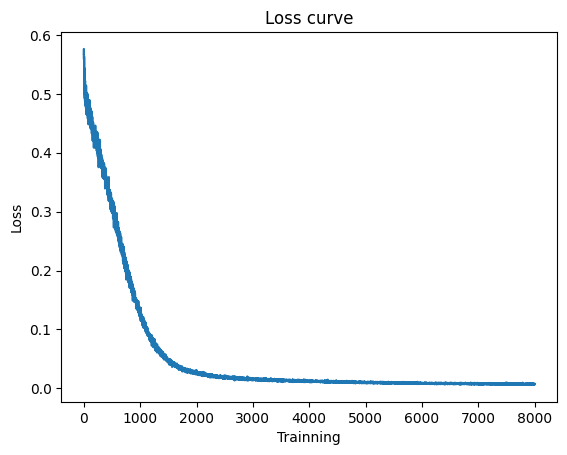

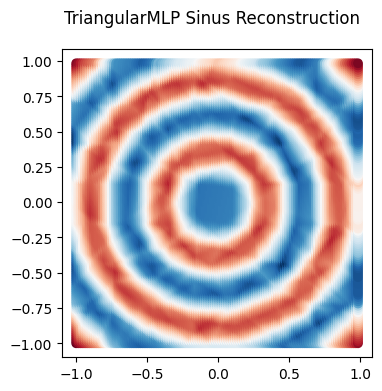

In [52]:
model = triangular_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=5,title="TriangularMLP Sinus Reconstruction")
print(model)

# Result of the 2D signal approximation,  moderate version

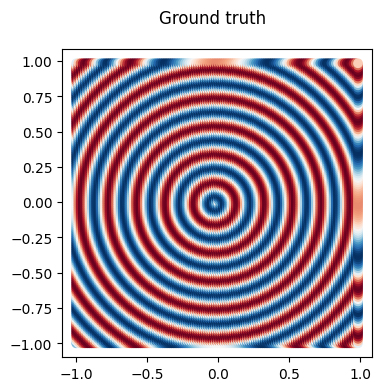

In [53]:
#moderate data
(data,label) = create_dataset_Helmholtz_max(size=128)
show_data(data,label,5,size=128)

Epoch: 1, Loss_train: 0.509 
Epoch: 51, Loss_train: 0.493 
Epoch: 101, Loss_train: 0.494 
Epoch: 151, Loss_train: 0.496 
Epoch: 201, Loss_train: 0.490 
Epoch: 251, Loss_train: 0.487 
Epoch: 301, Loss_train: 0.482 
Epoch: 351, Loss_train: 0.493 
Epoch: 401, Loss_train: 0.456 
Epoch: 451, Loss_train: 0.454 
Finished with a loss for 100 last loss :  0.45928943
Finished with a loss for 50 last loss :  0.4593993
simple_mlp_Helmholtz(
  (fc_1): Linear(in_features=2, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


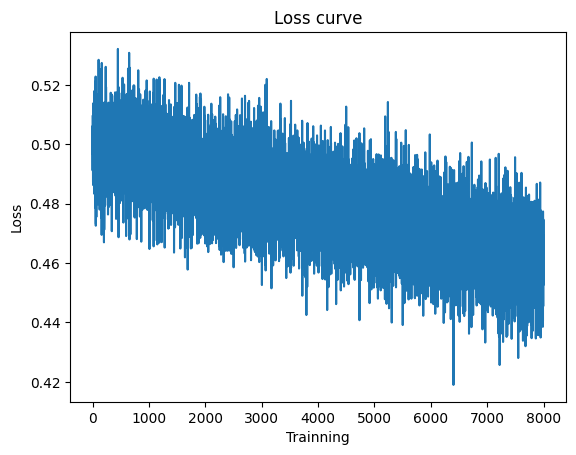

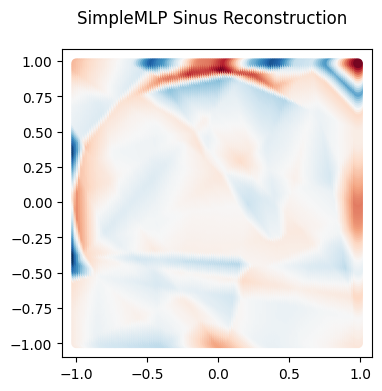

In [54]:
model = simple_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz_max(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=1,title="SimpleMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.527 
Epoch: 51, Loss_train: 0.019 
Epoch: 101, Loss_train: 0.007 
Epoch: 151, Loss_train: 0.005 
Epoch: 201, Loss_train: 0.004 
Epoch: 251, Loss_train: 0.004 
Epoch: 301, Loss_train: 0.004 
Epoch: 351, Loss_train: 0.003 
Epoch: 401, Loss_train: 0.003 
Epoch: 451, Loss_train: 0.004 
Finished with a loss for 100 last loss :  0.0034036061
Finished with a loss for 50 last loss :  0.003389712
fourier_mlp_Helmholtz(
  (fourier_1): fourier_extract_full(in_features=2, out_features=81, bias=True)
  (fc_2): Linear(in_features=81, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


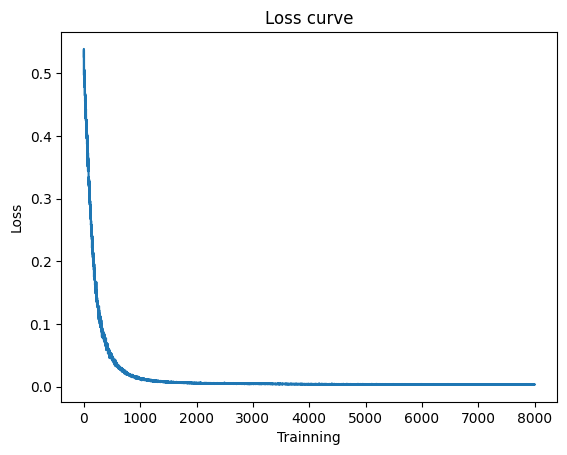

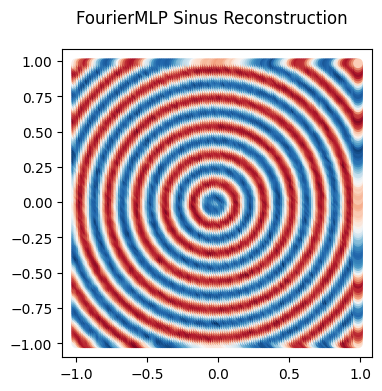

In [55]:
model = fourier_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz_max(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=2,title="FourierMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.901 
Epoch: 51, Loss_train: 0.007 
Epoch: 101, Loss_train: 0.007 
Epoch: 151, Loss_train: 0.006 
Epoch: 201, Loss_train: 0.005 
Epoch: 251, Loss_train: 0.006 
Epoch: 301, Loss_train: 0.006 
Epoch: 351, Loss_train: 0.005 
Epoch: 401, Loss_train: 0.005 
Epoch: 451, Loss_train: 0.005 
Finished with a loss for 100 last loss :  0.005891587
Finished with a loss for 50 last loss :  0.006038465
siren_mlp_Helmholtz(
  (siren): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=2, out_features=32, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=32, out_features=32, bias=True)
      )
      (2): SineLayer(
        (linear): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
)


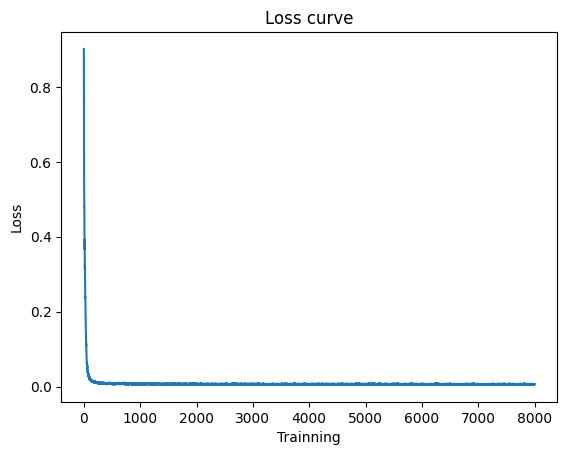

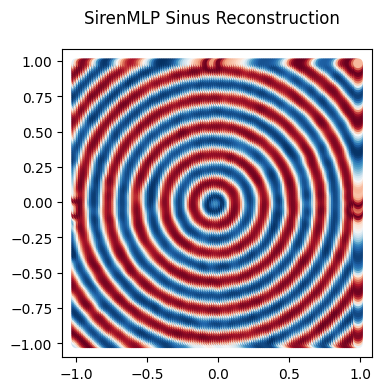

In [56]:
model = siren_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz_max(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=4,title="SirenMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.502 
Epoch: 51, Loss_train: 0.487 
Epoch: 101, Loss_train: 0.492 
Epoch: 151, Loss_train: 0.468 
Epoch: 201, Loss_train: 0.468 
Epoch: 251, Loss_train: 0.441 
Epoch: 301, Loss_train: 0.447 
Epoch: 351, Loss_train: 0.437 
Epoch: 401, Loss_train: 0.449 
Epoch: 451, Loss_train: 0.418 
Finished with a loss for 100 last loss :  0.41410026
Finished with a loss for 50 last loss :  0.41399
triangular_mlp_Helmholtz(
  (input_decompo): triangular_features_extraction(in_features=2, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=1, bias=True)
)


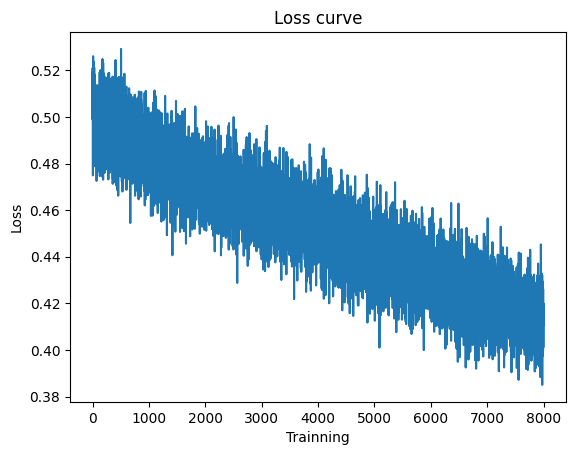

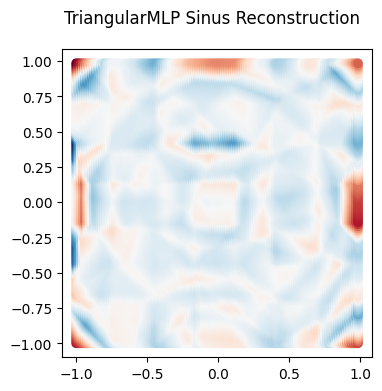

In [57]:
model = triangular_mlp_Helmholtz()
train_model(model,create_dataset_Helmholtz_max(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=5,title="TriangularMLP Sinus Reconstruction")
print(model)

# Result of the 2D signal approximation,  hard version

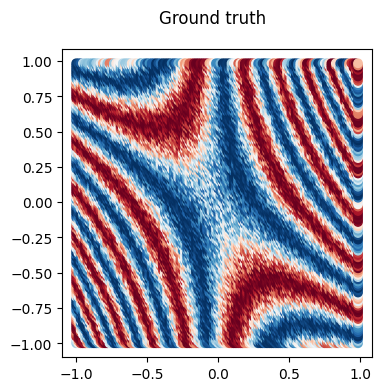

In [58]:
#hard data
(data,label) = create_dataset_hard(size=128)
show_data(data,label,5,size=128)

Epoch: 1, Loss_train: 0.477 
Epoch: 51, Loss_train: 0.382 
Epoch: 101, Loss_train: 0.327 
Epoch: 151, Loss_train: 0.273 
Epoch: 201, Loss_train: 0.244 
Epoch: 251, Loss_train: 0.235 
Epoch: 301, Loss_train: 0.227 
Epoch: 351, Loss_train: 0.230 
Epoch: 401, Loss_train: 0.213 
Epoch: 451, Loss_train: 0.189 
Finished with a loss for 100 last loss :  0.2003135
Finished with a loss for 50 last loss :  0.20046808
simple_mlp_Helmholtz(
  (fc_1): Linear(in_features=2, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


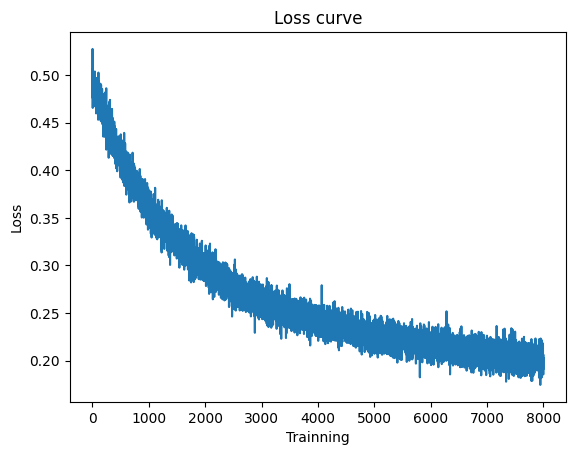

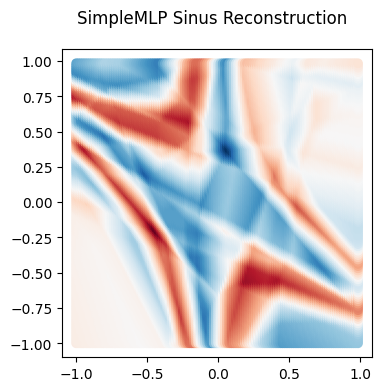

In [59]:
model = simple_mlp_Helmholtz()
train_model(model,create_dataset_hard(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=1,title="SimpleMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.524 
Epoch: 51, Loss_train: 0.048 
Epoch: 101, Loss_train: 0.044 
Epoch: 151, Loss_train: 0.042 
Epoch: 201, Loss_train: 0.041 
Epoch: 251, Loss_train: 0.041 
Epoch: 301, Loss_train: 0.037 
Epoch: 351, Loss_train: 0.043 
Epoch: 401, Loss_train: 0.036 
Epoch: 451, Loss_train: 0.039 
Finished with a loss for 100 last loss :  0.0392706
Finished with a loss for 50 last loss :  0.03918043
fourier_mlp_Helmholtz(
  (fourier_1): fourier_extract_full(in_features=2, out_features=81, bias=True)
  (fc_2): Linear(in_features=81, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=1, bias=True)
)


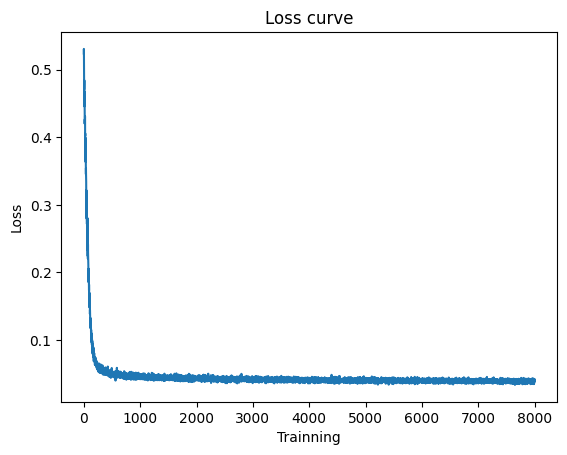

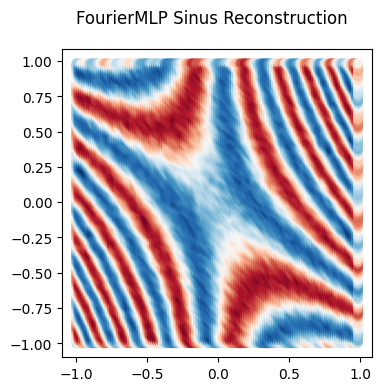

In [60]:
model = fourier_mlp_Helmholtz()
train_model(model,create_dataset_hard(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=2,title="FourierMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 1.163 
Epoch: 51, Loss_train: 0.056 
Epoch: 101, Loss_train: 0.075 
Epoch: 151, Loss_train: 0.063 
Epoch: 201, Loss_train: 0.063 
Epoch: 251, Loss_train: 0.065 
Epoch: 301, Loss_train: 0.065 
Epoch: 351, Loss_train: 0.061 
Epoch: 401, Loss_train: 0.068 
Epoch: 451, Loss_train: 0.065 
Finished with a loss for 100 last loss :  0.06779426
Finished with a loss for 50 last loss :  0.06752376
siren_mlp_Helmholtz(
  (siren): Siren(
    (net): Sequential(
      (0): SineLayer(
        (linear): Linear(in_features=2, out_features=32, bias=True)
      )
      (1): SineLayer(
        (linear): Linear(in_features=32, out_features=32, bias=True)
      )
      (2): SineLayer(
        (linear): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
)


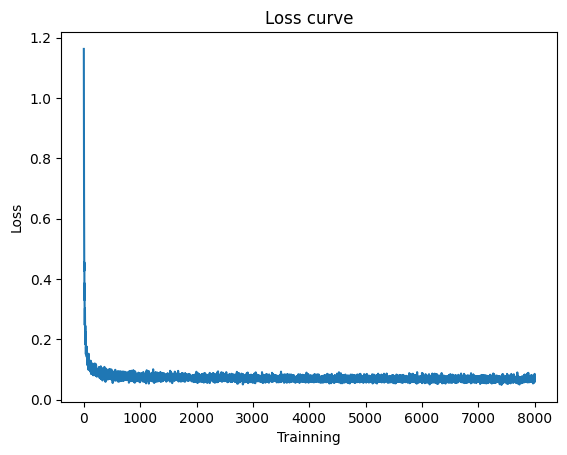

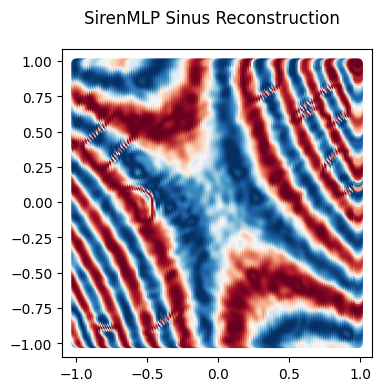

In [61]:
model = siren_mlp_Helmholtz()
train_model(model,create_dataset_hard(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=4,title="SirenMLP Sinus Reconstruction")
print(model)

Epoch: 1, Loss_train: 0.527 
Epoch: 51, Loss_train: 0.316 
Epoch: 101, Loss_train: 0.282 
Epoch: 151, Loss_train: 0.243 
Epoch: 201, Loss_train: 0.225 
Epoch: 251, Loss_train: 0.201 
Epoch: 301, Loss_train: 0.198 
Epoch: 351, Loss_train: 0.193 
Epoch: 401, Loss_train: 0.181 
Epoch: 451, Loss_train: 0.182 
Finished with a loss for 100 last loss :  0.1745409
Finished with a loss for 50 last loss :  0.17428207
triangular_mlp_Helmholtz(
  (input_decompo): triangular_features_extraction(in_features=2, out_features=16, bias=True)
  (fc_1): Linear(in_features=16, out_features=32, bias=True)
  (fc_2): Linear(in_features=32, out_features=1, bias=True)
)


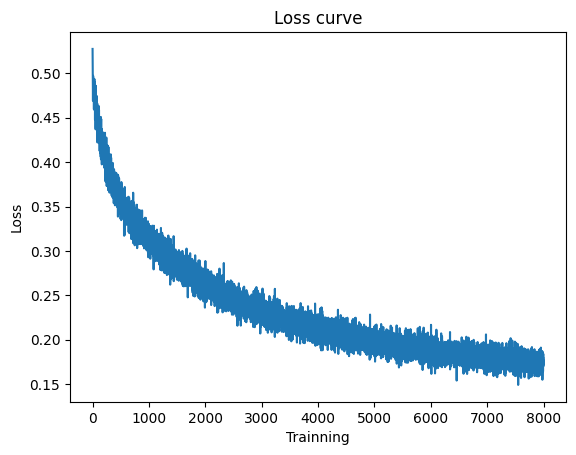

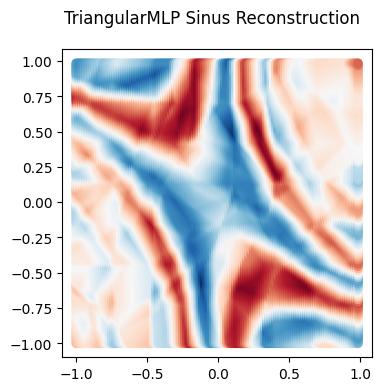

In [62]:
model = triangular_mlp_Helmholtz()
train_model(model,create_dataset_hard(),epochs=500,plot_step=50)
reconstruct_Helmholtz(model,index=5,title="TriangularMLP Sinus Reconstruction")
print(model)